In [1]:
import xupy as xp
import matplotlib.pyplot as plt
from ekarus.e2e.cascading_stage_ao_class import CascadingAO
from ekarus.e2e.utils.image_utils import reshape_on_mask, remap_on_new_mask
from numpy.ma import masked_array

from ekarus.analytical.kl_modes import make_modal_base_from_ifs_fft


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
cascao = CascadingAO(tn='cascading_kl')

KL1,m2c1 = cascao.define_KL_modes(cascao.dm1,zern_modes=2,save_prefix='dm1_',oversampling=3)
KL2,m2c2 = cascao.define_KL_modes(cascao.dm2,zern_modes=2,save_prefix='dm2_',oversampling=3)

Modulating 0 [lambda/D] with 0 modulation steps
Unobscured actuators: 1250/1261


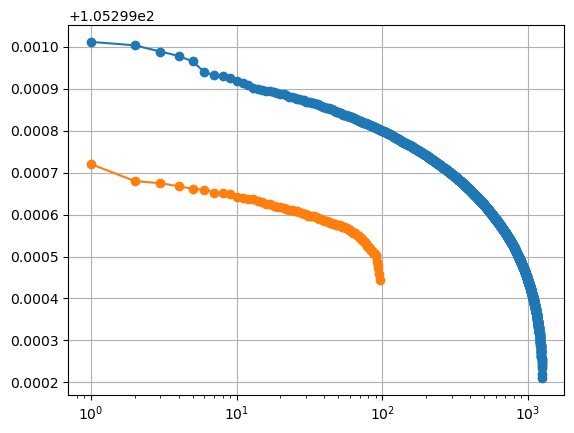

In [3]:
S1 = xp.linalg.svd(KL1,compute_uv=False)
S2 = xp.linalg.svd(KL2,compute_uv=False)

plt.figure()
plt.plot(xp.asnumpy(xp.arange(len(S1)))+1,xp.asnumpy(S1),'-o')
plt.plot(xp.asnumpy(xp.arange(len(S2)))+1,xp.asnumpy(S2),'-o')
plt.xscale('log')
plt.grid()

In [4]:
def filter_iffs(dm, modes):
    coeff2modes = modes.T
    modes2coeff = xp.linalg.pinv(coeff2modes)
    IFFs = dm.IFF.copy()
    if dm.slaving is not None: # slaving
        IFFs = remap_on_new_mask(dm.IFF, dm.mask, dm.pupil_mask)
        IFFs = IFFs[:,dm.master_ids]
    # filter modes
    coeffs = modes2coeff @ IFFs
    fit_modes = coeff2modes @ coeffs
    IFFs -= fit_modes
    return IFFs

In [5]:
# Filter the first N modes
N = 50
modes = KL2[:N,:]

IF1 = filter_iffs(cascao.dm1, modes)
IF2 = filter_iffs(cascao.dm2, modes)

cIF = xp.hstack([IF1,IF2])

hoKL, m2c, _ = make_modal_base_from_ifs_fft(1-cascao.cmask, cascao.pupilSizeInPixels,
    cascao.pupilSizeInM, cIF.T, r0=10e-2, L0=25, zern_modes=0, filt_modes = None,
    oversampling=3, if_max_condition_number=1e+3, verbose=True, dtype=xp.float, xp=xp)

Starting modal basis generation...
Input shapes: pupil_mask=(120, 120), influence_functions=(1347, 11088)
Step 1: Removing modes from influence functions...
Step 2: Calculating geometric covariance matrix...
Step 3: SVD decomposition of covariance matrix...
-- IF covariance matrix SVD ---
    initial condition number is: 3.1117607197832696e+16
    final condition number is: 665.8175030158847
    no. of cut modes: 154
Step 4: Calculating turbulence covariance matrix...
Computing turbulence covariance matrix...
Step 1: Computing Fourier transforms of influence functions...
Step 2: Generating phase spectrum and computing covariance matrix...
Step 3: Computing covariance matrix in Fourier domain...
Step 4: Computing covariance matrix in spatial domain...
Step 5: Calculating modal basis...
Final shapes: kl_basis=(1192, 11088), m2c=(1347, 1192)


1249 96 1242


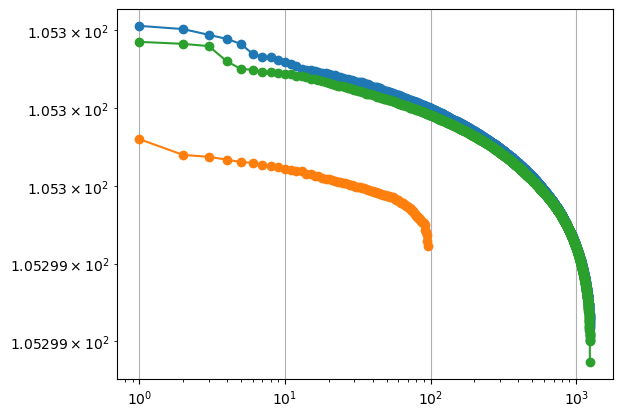

In [10]:
# Add the filtered modes back
KL = xp.vstack([modes,hoKL])

S = xp.linalg.svd(KL,compute_uv=False)

plt.figure()
plt.plot(xp.asnumpy(xp.arange(len(S1)))+1,xp.asnumpy(S1),'-o')
plt.plot(xp.asnumpy(xp.arange(len(S2)))+1,xp.asnumpy(S2),'-o')
plt.plot(xp.asnumpy(xp.arange(len(S)))+1,xp.asnumpy(S),'-o')
plt.xscale('log')
plt.yscale('log')
plt.grid()

print(len(S1),len(S2),len(S))

In [7]:
def plot_mode_j(pupil,Mat,j:int,title:str=''):
    mode = reshape_on_mask(Mat[:,j],(1-pupil).astype(bool))
    plt.imshow(masked_array(xp.asnumpy(mode),xp.asnumpy(1-pupil)),origin='lower',cmap='RdBu')
    plt.colorbar()
    plt.axis('off')
    plt.title(title)

def display_modes(pupil, Mat, N:int=8):
    nModes = xp.shape(Mat)[1]
    plt.figure(figsize=(2.25*N,12))
    for i in range(N):
        plt.subplot(6,N,i+1)
        plot_mode_j(pupil,Mat,i,title=f'Mode {i}')
        plt.subplot(6,N,i+1+N)
        plot_mode_j(pupil,Mat,i+N,title=f'Mode {i+N}')

        plt.subplot(6,N,i+1+N*2)
        plot_mode_j(pupil,Mat,nModes//2-N+i,title=f'Mode {nModes//2-N+i}')
        plt.subplot(6,N,i+1+N*3)
        plot_mode_j(pupil,Mat,nModes//2+N+i,title=f'Mode {nModes//2+N+i}')

        plt.subplot(6,N,i+1+N*4)
        plot_mode_j(pupil,Mat,nModes-2*N+i,title=f'Mode {nModes-2*N+i}')
        plt.subplot(6,N,i+1+N*5)
        plot_mode_j(pupil,Mat,nModes-N+i,title=f'Mode {nModes-N+i}')

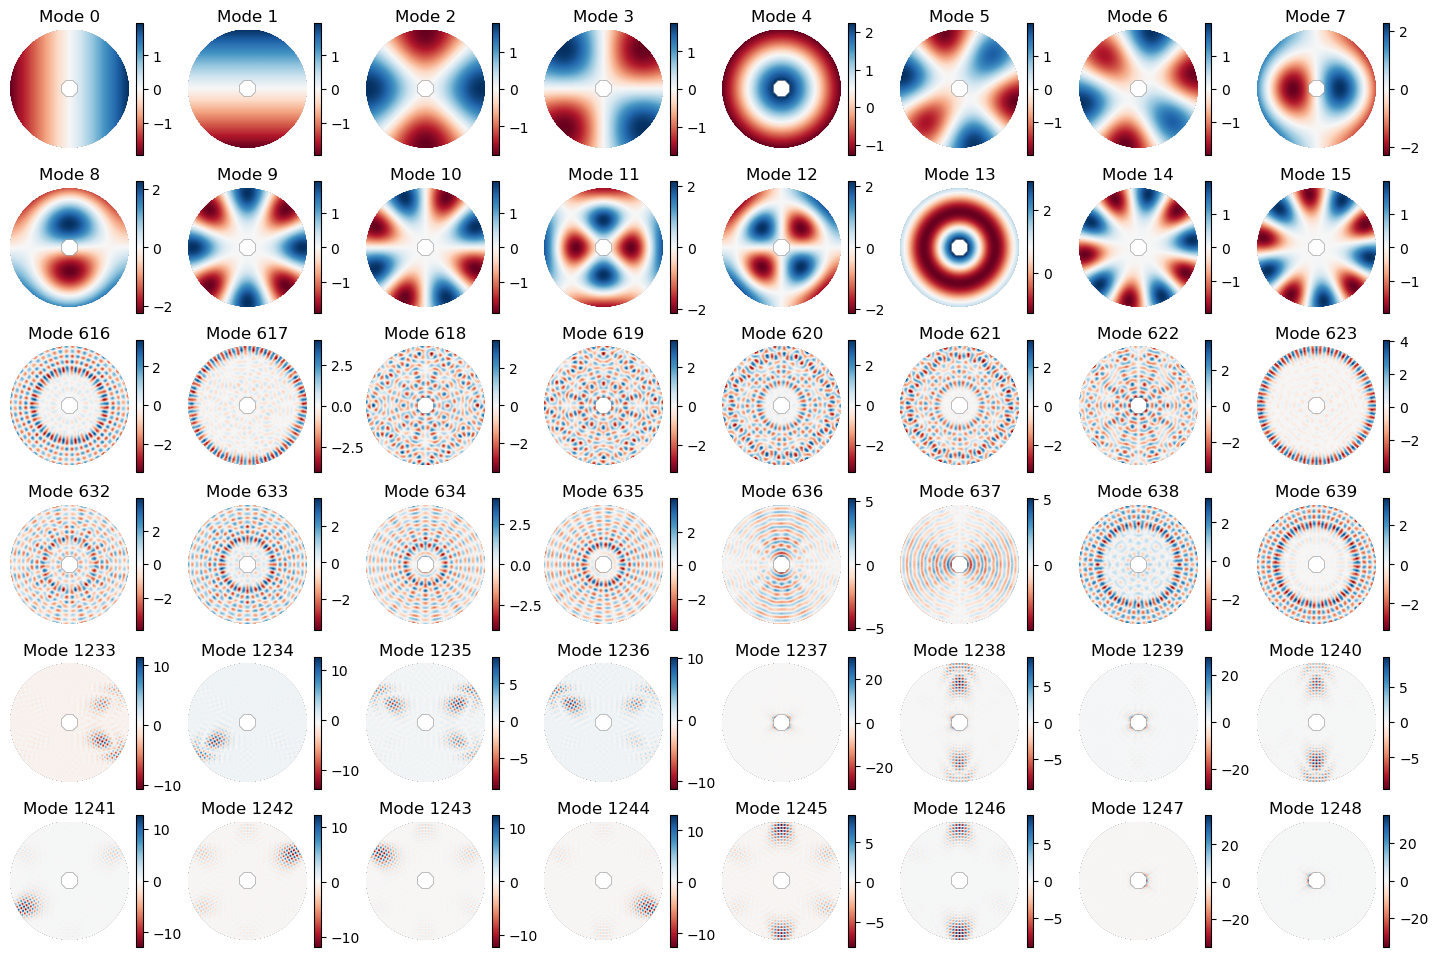

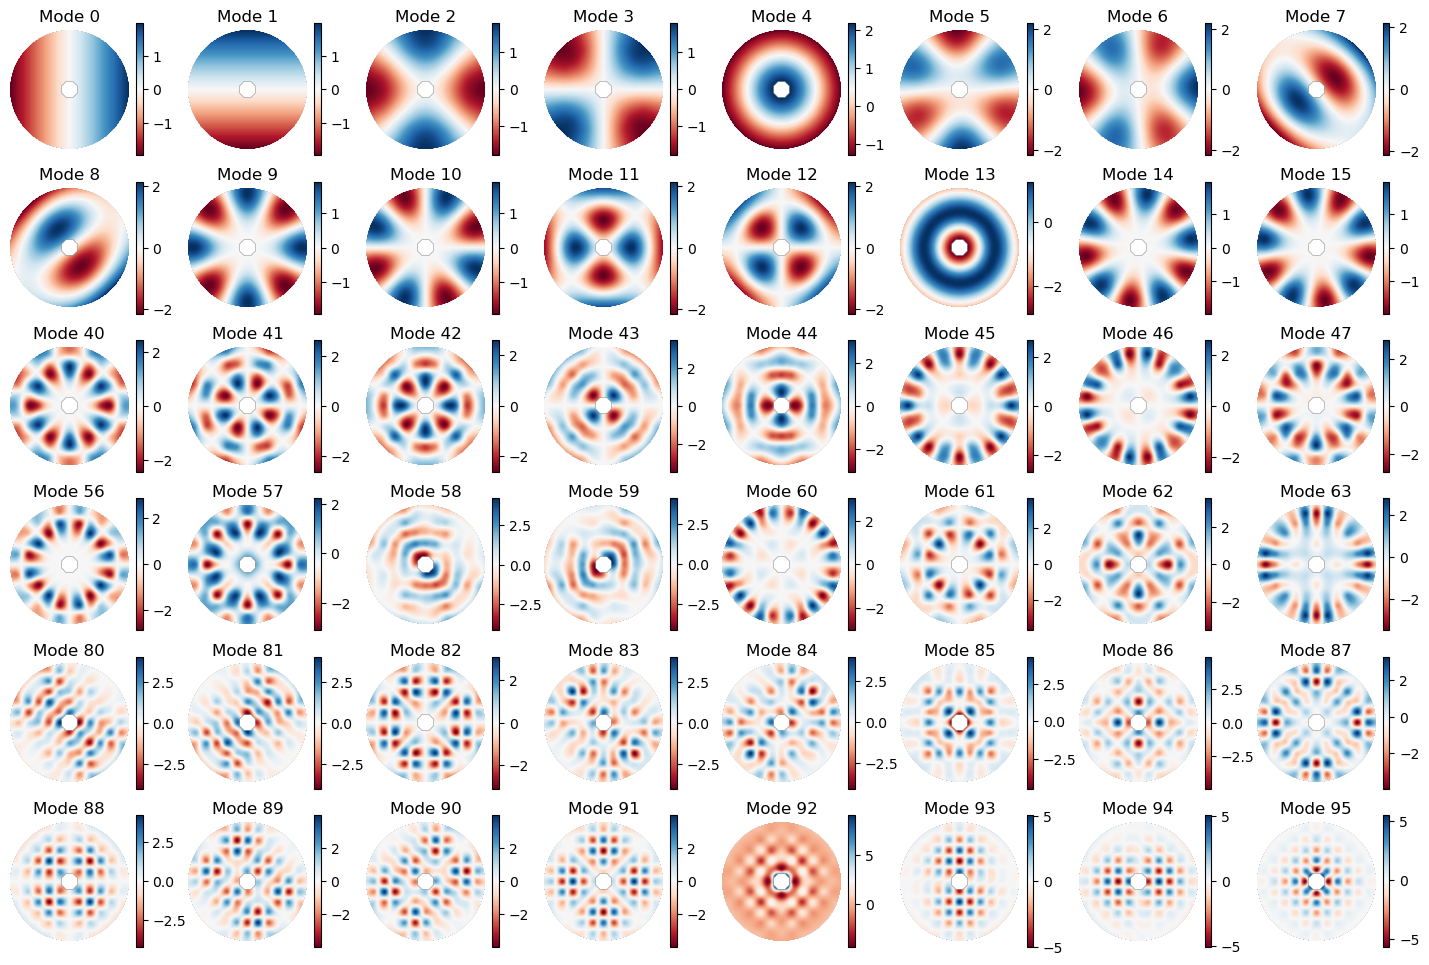

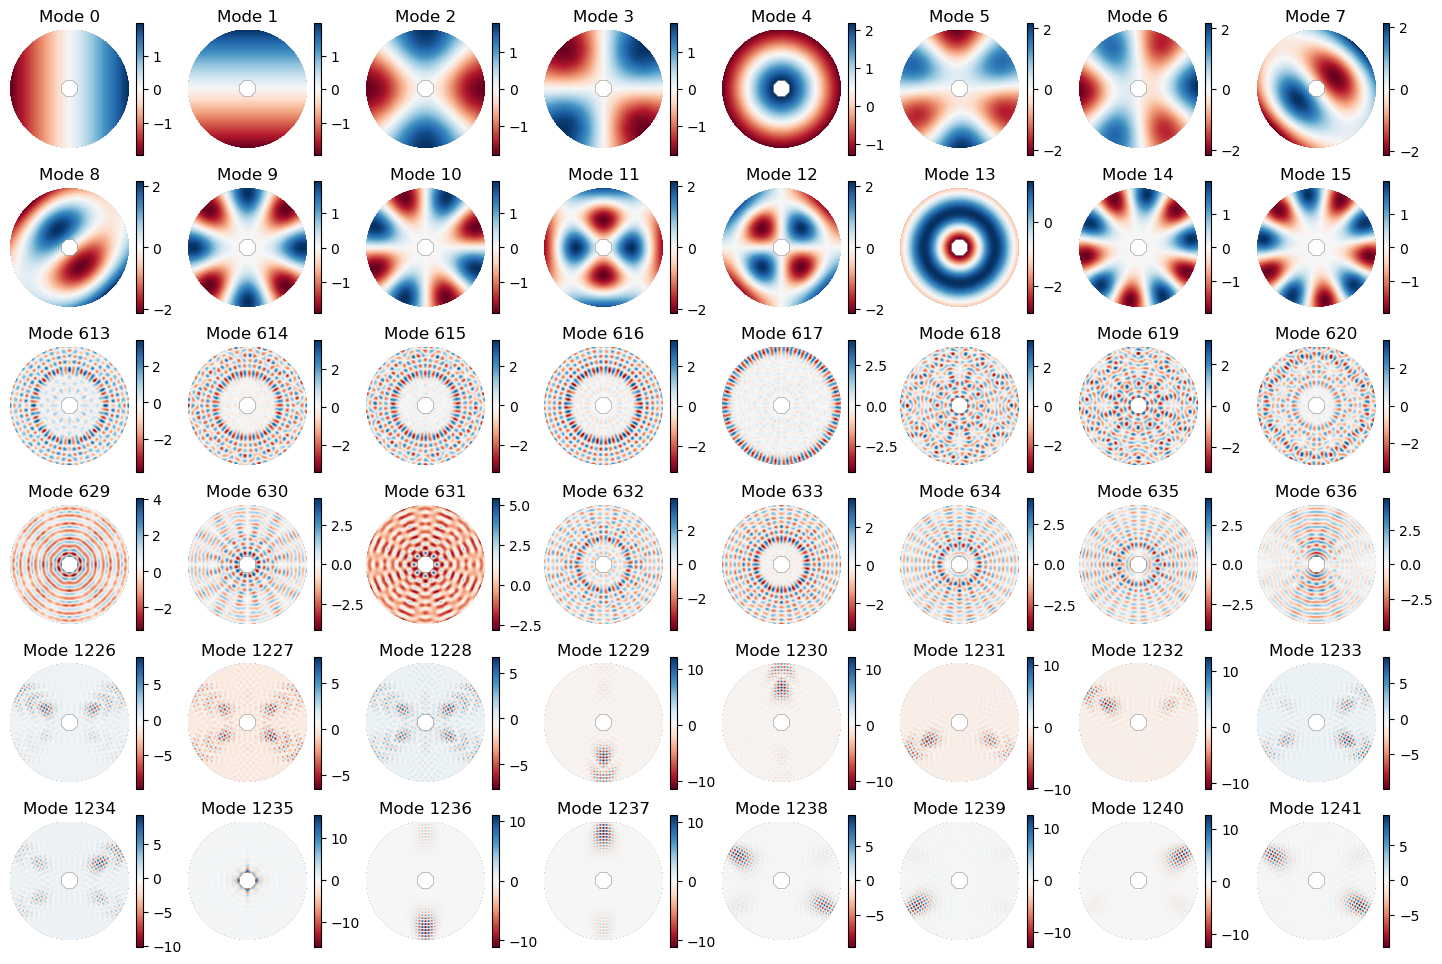

In [8]:
display_modes(1-cascao.cmask, xp.asnumpy(KL1.T))
display_modes(1-cascao.cmask, xp.asnumpy(KL2.T))
display_modes(1-cascao.cmask, xp.asnumpy(KL.T))